# Многоклассовая машина опорных векторов


В этом задании вы:
    
- реализуете полностью векторизованную **функцию потерь** для SVM
- создадите векторизованное выражение для **аналитического градиента**
- **проверите свою реализацию** с помощью числового градиента
- используете оценочную выборку для **настройки скорости обучения и силы регуляризации**
- **оптимизируете** функцию потерь с помощью **SGD**
- **визуализируете** окончательные веса


In [1]:

# Запустите эту ячейку для проверки работоспособности необходимых модулей.
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# Немного магии, чтобы заставить графики matplotlib появляться прямо внутри блокнота,
# а не в новом окне.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # размер графиков по умолчанию
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Больше магии с дополнительными Python-модулями можно найти здесь
# http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Загрузка и предварительная обработка CIFAR-10

In [2]:
g# Загружаем исходные данные CIFAR-10.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Очищаем переменные, чтобы данные можно было загружать много раз 
try:
   del X_train, y_train
   del X_test, y_test
   print('Очистка предыдущих данных.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# Выводим размер тестовых и обучающих данных
print('Объём обучающей выборки: ', X_train.shape)
print('Число обучающих меток: ', y_train.shape)
print('Объём тестовой выборки: ', X_test.shape)
print('Число тестовых меток: ', y_test.shape)

Объём обучающей выборки:  (50000, 32, 32, 3)
Число обучающих меток:  (50000,)
Объём тестовой выборки:  (10000, 32, 32, 3)
Число тестовых меток:  (10000,)


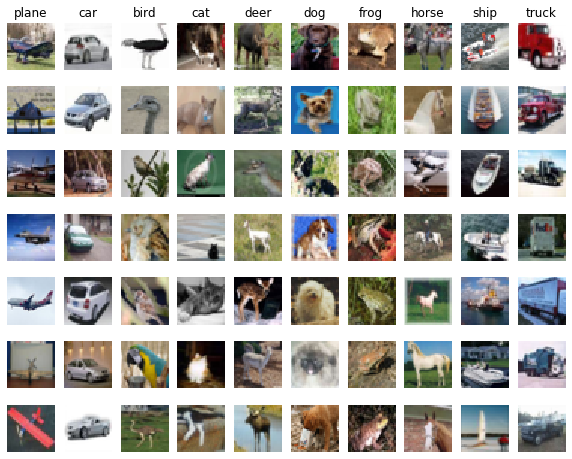

In [3]:
# Отображаем несколько примеров из тестового датасета.
# Посмотрим на несколько изображений из каждого класса.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Разделяем данные на обучающую, оценочную и тестовыю выборки. В дополнение
# к этому создадим небольшую подвыборку обучающих данных размером num_dev;
# которую сможем использовать для ускорения кода.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Создаём оценочную выборку
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Создаём обучающую выборку
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# Создаём подвыборку dev
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# Создаём тестовую выборку
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Объём обучающей выборки: ', X_train.shape)
print('Число обучающих меток: ', y_train.shape)
print('Объём оценочной выборки: ', X_val.shape)
print('Число оценочных меток: ', y_val.shape)
print('Объём тестовой выборки: ', X_test.shape)
print('Число тестовых меток: ', y_test.shape)

Объём обучающей выборки:  (49000, 32, 32, 3)
Число обучающих меток:  (49000,)
Объём оценочной выборки:  (1000, 32, 32, 3)
Число оценочных меток:  (1000,)
Объём тестовой выборки:  (1000, 32, 32, 3)
Число тестовых меток:  (1000,)


In [5]:
# Предварительная обработка: преобразуем данные в строки
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# Выводим размер данных
print('Объём обучающих данных: ', X_train.shape)
print('Объём оценочных данных: ', X_val.shape)
print('Объём тестовых данных: ', X_test.shape)
print('Объём данных dev: ', X_dev.shape)

Объём обучающих данных:  (49000, 3072)
Объём оценочных данных:  (1000, 3072)
Объём тестовых данных:  (1000, 3072)
Объём данных dev:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


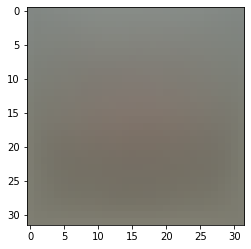

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [6]:
# Предварительная обработка: вычесть среднее изображение
# 1: вычисляем среднее значение изображения на основе обучающих данных
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# 2: Вычитаем среднее изображение из данных
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# 3: добавляем единичное смещение, чтобы наш SVM заботился только
# об оптимизации матрицы весов W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## Классификатор SVM

Реализуйте код для этого раздела, открыв файл **cs231n/classifiers/linear_svm.py**. 

Как вы можете видеть, функция `compute_loss_naive` уже написана: она использует циклы для оценки функции потерь мультиклассового SVM.

In [27]:
# Оцениваем потери наивной реализации:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# Генерируем рандомную матрицу весов SVM с небольшими значениями
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('Потери: %f' % (loss, ))

(10,)
4579.634496379879
(3073, 10) 10 500
(3073, 10)
-39.63271087841665
Потери: 9.159269


`Grad`, возвращённый из функции выше, сейчас равен нулю. Реализуйте его в функции `svm_loss_naive`.

Чтобы убедиться, что вы правильно реализовали градиент, можете использовать числовую оценку и сравнить её с вычисленным вами градиентом. Для этого используйте следующий код:

In [49]:
# Код ниже считает числовой градиент и сравнивает его с полученным вами
# в функции svm_loss_naive

# Считаем потери и градиент
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Вычисляем числовой градиент и сравниваем его с аналитическим
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# Делаем градиентную проверку снова, но уже с регуляризацией.
# Вы же не забыли про неё?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

(10,)
4579.634496379879
(3073, 10) 10 500
<function <lambda> at 0x7f18c46f48c0> Функция хз чего
-6.104959506913884e-05  cтарое значение функции
-5.104959506913884e-05 инкрементированное значение oldval + h
(10,)
4579.596995155794
(3073, 10) 10 500
9.159193990311588 вычисление f(x)
-7.104959506913884e-05 инкремент oldval - h
(10,)
4579.671997603961
(3073, 10) 10 500
9.159343995207923 вычисление f(x) для уменьшенного x
-0.00015000489633543168  - этап 1
2e-05  - этап 2
-7.500244816771583  - этап 3
numerical: -7.500245 analytic: -7.500245, relative error: 2.966916e-11
<function <lambda> at 0x7f18c46f48c0> Функция хз чего
0.00022354099989191286  cтарое значение функции
0.00023354099989191286 инкрементированное значение oldval + h
(10,)
4579.580271268449
(3073, 10) 10 500
9.159160542536897 вычисление f(x)
0.00021354099989191286 инкремент oldval - h
(10,)
4579.688968592787
(3073, 10) 10 500
9.159377937185575 вычисление f(x) для уменьшенного x
-0.00021739464867742697  - этап 1
2e-05  - этап 2


In [46]:
# Теперь реализуйте функцию svm_loss_vectorized: пока что только посчитайте потери.
# Градиент будет чуть позже
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Потери с помощью циклов: %e время на вычисление %fс' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Векторизованные потери: %e время на вычисление %fс' % (loss_vectorized, toc - tic))

# Потери должны совпадать, но векторизованная реализация должна работать гораздо быстрее.
print('Разница: %f' % (loss_naive - loss_vectorized))

(10,)
4579.634496379879
(3073, 10) 10 500
Потери с помощью циклов: 9.159269e+00 время на вычисление 0.404119с
(500, 10)
Векторизованные потери: 1.020615e+01 время на вычисление 0.020479с
Разница: -1.046885


In [51]:
# Завершите реализацию svm_loss_vectorized и вычислите градиент
# функции потерь с помощью векторов.

# Обе реализации (цикли и веткора) должны совпадать, векотризация
# должна ускорять процесс
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Потери и градиент, реализованные с помощью циклов: время на вычисление %fс' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Векторизованные потери и градент: время на вычисление %fс' % (toc - tic))

# Потери - это одно число, поэтому их довольно легко сравнивать для разных
# реализаций. Но градиенты - это матрицы, поэтому для их сравнения мы
# используем норму Фробениуса.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Разница: %f' % difference)

(10,)
4579.634496379879
(3073, 10) 10 500
Потери и градиент, реализованные с помощью циклов: время на вычисление 0.289152с
(500, 10)
Векторизованные потери и градент: время на вычисление 0.059900с
Разница: 0.000000


### Стохастический градиентный спуск

Теперь у нас есть потери и градиент. Приступим к оптимизации и используем стохастический градиентный спуск (SGD), чтобы минимизировать потери.

In [78]:
# В файле linear_classifier.py реализуйте алгоритм SGD в функции
# LinearClassifier.train(), а затем запустите код ниже.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('Это заняло %fс' % (toc - tic))

4542788366, 43.197195711305184, 42.910347432644755, 42.07467202312455, 42.2082088349515, 41.422417816669075, 41.31507752914937, 41.485658482885334, 41.40252464098984, 41.782124251270396, 40.704661649770124, 40.5809703624766, 40.237453278733426, 40.027267176437064, 39.93522527277441, 40.179253391467284, 40.312529884532005, 39.70926850913032, 39.527144186764545, 39.089634479614425, 39.118832084356185, 39.33043516206287, 38.77528452732406, 38.450731605518364, 38.47814051532559, 38.241376199418085, 38.21560983057111, 37.60728929751523, 37.71219156681763, 37.63705874602752, 37.173616686699894, 36.93489150629341, 36.75150668196757, 37.0471333964872, 36.78389060018375, 36.68842707458387, 36.57859323565354, 36.26563259175913, 35.851953581855675, 36.32708705438816, 35.82203840884188, 35.58012620133189, 34.87268217050637, 35.52176914607036, 35.908978627404906, 35.01870834276857, 35.62255271490531, 35.078450037379966, 34.48806593239082, 34.05835833288674, 33.954693063923656, 34.00622433995399, 34

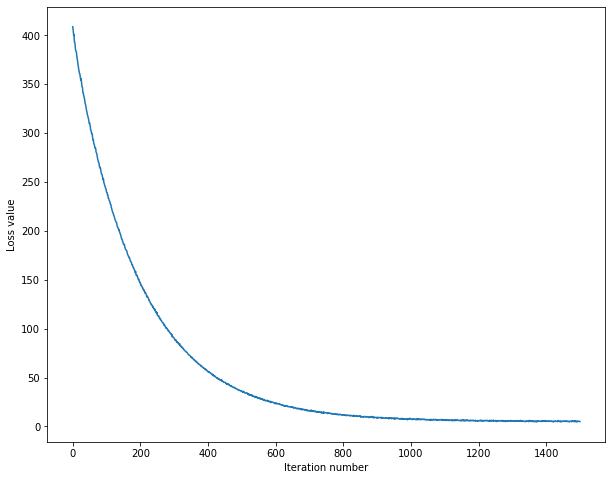

In [79]:
# Полезная стратегия отладки - вывод функции потерь для всех итераций
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [86]:
# Напишите функцию LinearSVM.predict и оцените эффективность на
# тестовой и оценочной выборках
y_train_pred = svm.predict(X_train)
print('Точность обучения: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('Точность оценки: %f' % (np.mean(y_val == y_val_pred), ))

(49000, 3073)
(49000, 10)
(49000,) [6 1 9 6 9 7 4 7 8 9 4 9 9 1 9 8 9 5 3 6 0 3 6 6 9 6 6 5 6 9 1 9 1 5 2 7 0
 7 8 1 6 3 4 7 9 3 1 8 2 0 2 6 4 0 6 2 7 6 6 9 1 1 8 2 1 1 4 9 7 8 2 6 9 1
 2 2 9 1 5 0 0 2 4 8 4 5 4 4 3 6 6 8 0 9 9 6 1 9 6 6]
Точность обучения: 0.381204
(1000, 3073)
(1000, 10)
(1000,) [8 3 8 3 6 6 0 0 4 3 7 9 9 8 4 3 2 1 8 7 6 1 5 1 0 8 9 6 0 1 4 9 5 7 5 9 1
 7 4 5 8 6 9 9 6 1 5 0 3 4 1 5 5 0 8 4 6 1 7 5 8 6 9 9 9 9 1 8 5 3 6 7 9 1
 3 1 7 4 3 8 6 3 9 3 8 8 8 8 1 2 8 0 7 3 6 5 8 4 6 4]
Точность оценки: 0.380000


In [ ]:
# Используйте оценочную выборку, чтобы настроить гиперпараметры (силу регялризации
# и скорость обучения). Поэкспереминтируйте с различными значениями; вы должны получить
# точность классификации около 0.39 на оценочной выборке.

# Обратите внимание: вы можете увидеть предупреждения runtime/overflow в процессе поиска 
# гиперпараметров. Они могут быть вызваны граничными значениями, поэтому не принимайте их за баг.

learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# В результате вы должны получить словарь, который отображает 
# (learning_rate, regularization_strength) в 
# (training_accuracy, validation_accuracy). Точность - это обычная
# доля правильно классифицированных данных.
results = {}
best_val = -1   # Самая высокая точность
best_svm = None # Классификатор LinearSVM, который достиг наилучшей точности

################################################################################
# TODO:                                                                        #
# Напишите код, который выбирает наилучшие гиперпараметры с помощью настройки  #
# на оценочной выборке. Для каждой комбинации параметров обучите линейный SVM  #
# на обучающей выборке, посчитайте его точность на тестовой и оценочной        #
# выборках, и сохраните эти значения в итоговый словарь. В дополнение к этому  #
# сохраните лучшую точность оценочной выборки в переменную best_val и лучший   #
# классификатор в best_svm.                                                    #
#                                                                              #
# Подсказка: Поначалу используйте небольшие значения num_iters, чтобы обучение #
# SVM не было слишком долгим. Как только вы реализуете и проверите код для     #
# оценки, можете вернуть более высокие значения num_iters.                     #
################################################################################
# *****START OF YOUR CODE*****

pass

# *****END OF YOUR CODE*****
    
# Выводим результаты.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('Скорость обучения: %e регуляризация: %e точность обучения: %f точность оценки: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('Лучшая точность, достигнутая в результате кросс-валидации: %f' % best_val)

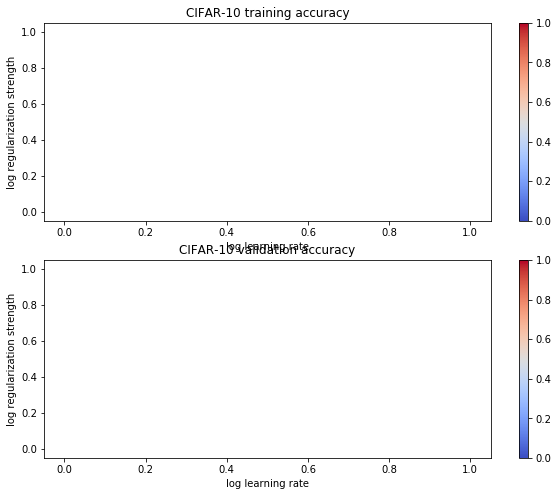

In [54]:
# Визуализируем результаты кросс-валидации
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# Выводим график точности обучения
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# График точности оценки
colors = [results[x][1] for x in results] # размер маркеров по умолчанию 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [ ]:
# Оцениваем лучший svm на тестовой выборке
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('Окончательная точность линейного SVM на тестовой выборке: %f' % test_accuracy)

In [ ]:
# Визуализируем веса для каждого класса.
# В завсимости от выбранных вами скорости обучения и силы регуляризации, это может
# выглядеть довольно неплохо (или наоборот).
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Масштабируем веса в диапазон 0...255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])